# GIN Index O(N^2) Lookup

I ran into an issue with using the && array operator on a GIN index of mine. Basically I have a query that looks like this:

```sql
SELECT * FROM example WHERE keys && ARRAY[...];
```

This works fine for a small number of array elements (N), but gets really slow as N gets bigger in what appears to be O(N^2) complexity.


However, from studying the GIN data structure as described by the docs, it seems that the performance for this could be O(N). In fact, it's possible to coerce the query planner into an O(N) plan like this:

```sql
SELECT DISTINCT ON (example.id) * FROM unnest(ARRAY[...]) key JOIN example ON keys && ARRAY[key]
```

The notebook below demonstrates this issue.

In [1]:
# Install dependencies
!pip3 install psycopg2-binary
!pip3 install pandas
!pip3 install matplotlib
!pip3 install numpy

In [2]:
# Import modules and setup matplotlib inlining and pandas row display options
%matplotlib inline
import psycopg2
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', 20)

In [3]:
# Connect to our database: you may change this DSN if you're not using the supplied docker-compose file.
# We also set autocommit to True so we can run VACUUUM (which is non-transactional) below.
pg_dsn = 'postgres://postgres@localhost:9999/postgres'
conn = psycopg2.connect(pg_dsn)
conn.autocommit = True
cur = conn.cursor()

In [4]:
# Create a table with lots of rows and array elements. You can see the data in the table below.
rows = 100000
keys_per_row = 3

cur.execute("""
DROP SCHEMA IF EXISTS gin CASCADE;
CREATE SCHEMA gin;
SET search_path = gin;

CREATE TABLE example AS
SELECT 
	a AS id,
	array_agg((a-1)*%s+b) AS keys
FROM
	generate_series(1, %s) a,
	generate_series(1, %s) b
GROUP BY 1;
CREATE INDEX ON example USING GIN (keys);
""", (keys_per_row, rows, keys_per_row))
cur.execute('VACUUM ANALYZE example')

pd.read_sql_query('SELECT * from example ORDER BY id ASC', con=conn)

,id,keys
0,1,"[1, 2, 3]"
1,2,"[4, 5, 6]"
2,3,"[7, 8, 9]"
3,4,"[10, 11, 12]"
4,5,"[13, 14, 15]"
5,6,"[16, 17, 18]"
6,7,"[19, 20, 21]"
7,8,"[22, 23, 24]"
8,9,"[25, 26, 27]"
9,10,"[28, 29, 30]"


In [5]:
# The two queries we'll benchmark. query_1 is the main query we are interested in. query_2 produces the same result
# and is included for comparison.
query_1 = "EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s"
query_2 = "EXPLAIN ANALYZE SELECT DISTINCT ON (example.id) * FROM unnest(%s) key JOIN example ON keys && ARRAY[key]"

In [6]:
# Force the query planner to use our gin index, even if it would prefer a seqscan and show 
# the query plans for the queries we're testing elow. 
cur.execute("SET enable_seqscan=false")

# Show the query plans for our two queries
for q in [query_1, query_2]:
    cur.execute(q, ([1,2,3],))
    print(q+'\n'+'\n'.join([x[0] for x in cur.fetchall()])+'\n\n')

EXPLAIN ANALYZE SELECT * FROM example WHERE keys && %s
Bitmap Heap Scan on example  (cost=51.57..924.35 rows=1493 width=37) (actual time=0.041..0.050 rows=1 loops=1)
  Recheck Cond: (keys && '{1,2,3}'::integer[])
  Heap Blocks: exact=1
  ->  Bitmap Index Scan on example_keys_idx  (cost=0.00..51.19 rows=1493 width=0) (actual time=0.029..0.033 rows=1 loops=1)
        Index Cond: (keys && '{1,2,3}'::integer[])
Planning Time: 0.196 ms
Execution Time: 0.096 ms


EXPLAIN ANALYZE SELECT DISTINCT ON (example.id) * FROM unnest(%s) key JOIN example ON keys && ARRAY[key]
Unique  (cost=18850.84..19350.84 rows=100000 width=45) (actual time=0.263..0.321 rows=1 loops=1)
  ->  Sort  (cost=18850.84..19100.84 rows=100000 width=45) (actual time=0.253..0.291 rows=3 loops=1)
        Sort Key: example.id
        Sort Method: quicksort  Memory: 25kB
        ->  Nested Loop  (cost=18.99..7469.52 rows=100000 width=45) (actual time=0.044..0.229 rows=3 loops=1)
              ->  Function Scan on unnest key  (cos

In [7]:
# Run our benchmark, basically just running the queries from above with an increasing amount of elements in the
# array we're performing an overlap operation with.
step = 100
steps = 200
results = []

def gin_query(sql, args):
    cur.execute(sql, args)
    plan = '\n'.join([x[0] for x in cur.fetchall()])
    
    # make sure all our queries used our GIN index
    if plan.find('Index Scan') < 0:
        raise Exception("unexpected query plan")
    time = float(re.search('Execution time: ([0-9.]+)', plan, flags=re.IGNORECASE)[1])
    return time


for p in range(steps):
    keys = [k+1 for k in range(step * (p+1))]
    time_1 = gin_query(query_1, (keys,))
    time_2 = gin_query(query_2, (keys,))

    result = (len(keys), time_1, time_2)
    results.append(result)

df = pd.DataFrame(results, columns=["keys", "time_1", "time_2"])
df

,keys,time_1,time_2
0,100,0.902,7.212
1,200,1.499,12.731
2,300,2.639,18.698
3,400,3.412,19.303
4,500,3.833,22.044
5,600,6.082,24.765
6,700,6.581,28.815
7,800,8.171,33.357
8,900,10.063,37.146
9,1000,12.012,41.326


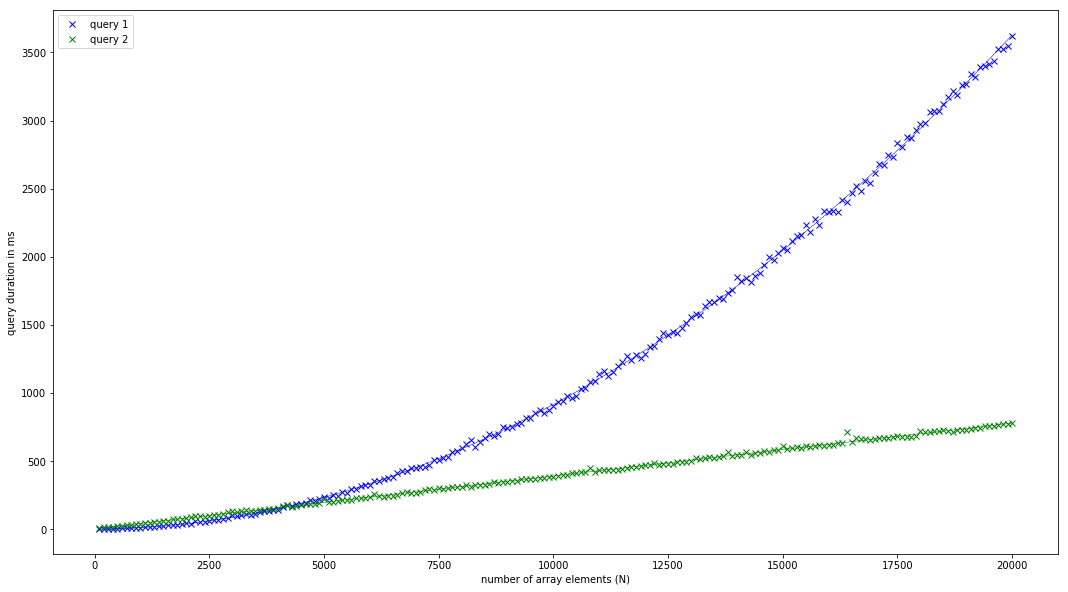

In [8]:
# fit a quadratic curve to our first query
coef_1 = np.polyfit(df['keys'], df['time_1'], 2)
p_1 = np.poly1d(coef_1)
# fit a straight line to our second query 
coef_2 = np.polyfit(df['keys'], df['time_2'], 1)
p_2 = np.poly1d(coef_2)


fig, ax = plt.subplots()
fig.set_size_inches((18, 10))
ax.plot(df['keys'], df['time_1'], "bx", markersize=6, label='query 1')
ax.plot(df['keys'], df['time_2'], "gx", markersize=6, label='query 2')
ax.plot(df['keys'], p_1(df['keys']), "b-", linewidth=0.5)
ax.plot(df['keys'], p_2(df['keys']), "g-", linewidth=0.5)
ax.set_xlabel('number of array elements (N)')
ax.set_ylabel('query duration in ms')
ax.legend()

ax